<a href="https://colab.research.google.com/github/Carlosmagnobrusil/Food_sales_predictions/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Prediccion de ventas**
## *Creado por: Carlos Brusil*



*   Fecha de Creación: 14 de enero de 2022 
*   Fechad de actualización: 28 de enero de 2022
*   Descripción: En esta actualización se realizó una revisión de la limpieza de datos y se realizan graficos lo cuuales nos ayudaran a observar cual es el estado de los datos, para tener una idea si se necesitara realizar ajustes de estos datos para el futuro modelo  

### Carga de datos 

In [73]:
from google.colab import drive
drive.mount('/content/drive') # uno my Drive al nuevo cuaderno


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import pandas as pd #importo la libreria panda permite manipular y molderar los datos 
import numpy as np #importo la libreria numpy manipular y molderar los datos 
import matplotlib.pyplot as plt #importo libreria matplotlib que es una libreria que me permite realizar graficas en 2 dimensiones de de mis datos
from matplotlib import pyplot as pyplot #
import seaborn as sns #Esta libreria nos permite modificar la vizualizacion de los datos atraves de los coleres y mejorar presetancion de los mismo 
from sklearn.linear_model import LinearRegression #para realizar regresiones y modelos
from sklearn.preprocessing import StandardScaler #Herramienta para la estandarizaci[on de datos
from sklearn.neighbors import KNeighborsClassifier #herramienta que permite crear modelos KNN de clasificacion
from sklearn.neighbors import KNeighborsRegressor #herramienta que permite crear modelos KNN de regresion
from sklearn.model_selection import train_test_split #herramienta para validacion prueba entrebamiento
from sklearn.ensemble import BaggingClassifier #herramiento de clasificacion para bagged trees
from sklearn.ensemble import RandomForestClassifier #herramienta de para generar bosques aleatorios
from sklearn.ensemble import BaggingRegressor #Herramienta de regresion arboles baggin
from sklearn.tree import DecisionTreeRegressor #herramienta de creacion de arboles de regresion 
from sklearn.ensemble import RandomForestRegressor #herramienta para la creacion de bosque aleatorio de regresion
from sklearn.tree import export_text #extraccion de las reglas del arbol 
from sklearn import tree#herramienta de vizualizacion de arboles 
from sklearn import metrics

In [75]:
sales_data =  '/content/drive/MyDrive/Coding_Dojo/Proyecto /Data/sales_predictions.csv' #Nombro a la base
sales_df = pd.read_csv(sales_data) #le doy un nombre a la trama 
#de datos  ene ste caso el sugerido en la tarea como no tiene titulos el archivo txt uso el metodo header y que mantega los 
#valores vacios con na 
sales_df.head() #Observo que los datos hayan sido leidos de forma correcta

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Revisión de la base de datos 

In [76]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [77]:
# en el siguiente codigo creare un codigo que me permita calcular el ratio de valores perdidos para cada columna.
mv = sales_df.isnull().sum() # creo una variable que realice la suma de cada missing values de las columnas del data frame
td = len(sales_df) #creo una variable que cuente la longitud de los datos totales de mi data frame
mvrt = round(((mv/td)*100),2) #creo el ratio que itera cada columna del data frame y lo divide para el total de observaciones 
#se multiplica porcien para obtener un valor en porcentaje y se lo redonde a 2 decimales   
mvrt #este ratio muestra cual es el porcentaje de datos perdidos 

Item_Identifier               0.00
Item_Weight                  17.17
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.28
Outlet_Location_Type          0.00
Outlet_Type                   0.00
Item_Outlet_Sales             0.00
dtype: float64

#### Se observa en la primeria linea de data que los valores perdidos del peso del producto no rebasan al **20%** por lo cual la limpieza de esta data, se realizara de la siguinte manera primero se llenaran los datos de el tamaño de los minoristas con la moda de la columna y se procede a eliminar el resto de la data del peso del producto. Esto en una primera revision.

#### Se realizara una segunda revison a profundidad del peso de los datos para ver si merece la pena elimianr estos datos 

In [78]:
itemweigth_var =  sales_df.groupby(['Item_Identifier'])['Item_Weight'].var()
#La linea de codigo anterior es para conocer cual es el peso minimo que se esta entregando en cada local por producto    
itemweigth_var.unique()

array([ 0., nan])

#### Se observa que los unicos valores son 0 y los valores perdidos que al observar la varianza de los mismos, podemos asegurar que los valores de la comida se repiten por lo cual se organizara la base en orden los objetos y se llenaran los valores perdidos 

In [79]:
sales_df = sales_df.sort_values(['Item_Identifier'], ascending=False) #Como los peso de los productos son iguales en todas las observaciones 
#primero realizo un ordenamiento por el peso para poder usar el metodo con el valor siguiente de cada item que se encuentra perdido 
sales_df=sales_df.reset_index() #reseteo el index para que al momento de llenar los datos con el bfill no equivoque

In [80]:
sales_df['Item_Weight'].fillna(method = 'bfill', inplace = True) # esta liena le pido llenar el balor de los vaores NA con el valor anterior al estar ordenados
#por el identificador de item tomaran los mismo valores del item 
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      8523 non-null   int64  
 1   Item_Identifier            8523 non-null   object 
 2   Item_Weight                8523 non-null   float64
 3   Item_Fat_Content           8523 non-null   object 
 4   Item_Visibility            8523 non-null   float64
 5   Item_Type                  8523 non-null   object 
 6   Item_MRP                   8523 non-null   float64
 7   Outlet_Identifier          8523 non-null   object 
 8   Outlet_Establishment_Year  8523 non-null   int64  
 9   Outlet_Size                6113 non-null   object 
 10  Outlet_Location_Type       8523 non-null   object 
 11  Outlet_Type                8523 non-null   object 
 12  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage:

In [81]:
mode_outletsize = sales_df['Outlet_Size'].mode()
mode_outletsize #otengo cual tamaño de tienda es el man comun estre los reatilers 

0    Medium
dtype: object

In [82]:
sales_df['Outlet_Size'].fillna('Medium',inplace=True)  #lleno los missing values con el valor encontrado como Moda
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      8523 non-null   int64  
 1   Item_Identifier            8523 non-null   object 
 2   Item_Weight                8523 non-null   float64
 3   Item_Fat_Content           8523 non-null   object 
 4   Item_Visibility            8523 non-null   float64
 5   Item_Type                  8523 non-null   object 
 6   Item_MRP                   8523 non-null   float64
 7   Outlet_Identifier          8523 non-null   object 
 8   Outlet_Establishment_Year  8523 non-null   int64  
 9   Outlet_Size                8523 non-null   object 
 10  Outlet_Location_Type       8523 non-null   object 
 11  Outlet_Type                8523 non-null   object 
 12  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage:

In [83]:
sales_df['Item_Fat_Content'] = sales_df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular','low fat': 'Low Fat'})

### Estadistica descriptiva 

In [84]:
sales_df.head() #reviso la base antes de countinuar con la estadistica descriptiva 

,index,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,2839,NCZ54,14.65,Low Fat,0.083359,Household,161.9552,OUT046,1997,Small,Tier 1,Supermarket Type1,4711.2008
1,214,NCZ54,14.65,Low Fat,0.000000,Household,161.5552,OUT010,1998,Medium,Tier 3,Grocery Store,324.9104
2,7166,NCZ54,14.65,Low Fat,0.145952,Household,160.9552,OUT019,1985,Small,Tier 1,Grocery Store,162.4552
3,1969,NCZ54,14.65,Low Fat,0.083528,Household,162.4552,OUT045,2002,Medium,Tier 2,Supermarket Type1,2274.3728
4,1896,NCZ54,14.65,Low Fat,0.082956,Household,164.0552,OUT027,1985,Medium,Tier 3,Supermarket Type3,5523.4768


In [85]:
round(sales_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']].describe(),2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.65,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


#### Este cuadro nos permite observar de manera muy superficial la data continua donde podemos inferir que existen varios outlayers debido a la diferencia entre el maximo y el minimo 

In [86]:
round(sales_df.agg(
    {'Item_Weight': ["min", "max", "median", "skew"],
     'Item_Visibility': ["min", "max", "median", "skew"], 
     'Item_MRP': ["min", "max", "median", "skew"], 
     'Outlet_Establishment_Year': ["min", "max", "median", "skew"], 
     'Item_Outlet_Sales': ["min", "max", "median", "skew"]}
    ),2) #Obtengo los momentos de las variables continuas 

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,4.56,0.00,31.29,1985.0,33.29
max,21.35,0.33,266.89,2009.0,13086.96
median,12.60,0.05,143.01,1999.0,1794.33
skew,0.08,1.17,0.13,-0.4,1.18


In [87]:
sales_df[['Item_Fat_Content','Outlet_Size','Outlet_Location_Type']].value_counts()

Item_Fat_Content  Outlet_Size  Outlet_Location_Type
Low Fat           Medium       Tier 3                  1562
                               Tier 2                  1203
                  Small        Tier 1                   944
Regular           Medium       Tier 3                   856
                               Tier 2                   652
Low Fat           High         Tier 3                   606
                  Small        Tier 2                   606
                  Medium       Tier 1                   596
Regular           Small        Tier 1                   514
                  Medium       Tier 1                   334
                  High         Tier 3                   326
                  Small        Tier 2                   324
dtype: int64

#### En este codigo observamos que las categorias de contenido de grasa estan mal clasificadas por lo cual cambiare los valores en codigos superiores para no afectar la continuidad 

### Gráficos 

In [88]:
item_type2 = sales_df.groupby('Item_Type')['Item_Weight'].count()
item_type2

Item_Type
Baking Goods              648
Breads                    251
Breakfast                 110
Canned                    649
Dairy                     682
Frozen Foods              856
Fruits and Vegetables    1232
Hard Drinks               214
Health and Hygiene        520
Household                 910
Meat                      425
Others                    169
Seafood                    64
Snack Foods              1200
Soft Drinks               445
Starchy Foods             148
Name: Item_Weight, dtype: int64

In [89]:
item_df = item_type2.reset_index()
item_df

,Item_Type,Item_Weight
0,Baking Goods,648
1,Breads,251
2,Breakfast,110
3,Canned,649
4,Dairy,682
5,Frozen Foods,856
6,Fruits and Vegetables,1232
7,Hard Drinks,214
8,Health and Hygiene,520
9,Household,910


In [90]:
item_df = item_df.rename(columns={'Item_Weight':'Item_Count'})
item_df

,Item_Type,Item_Count
0,Baking Goods,648
1,Breads,251
2,Breakfast,110
3,Canned,649
4,Dairy,682
5,Frozen Foods,856
6,Fruits and Vegetables,1232
7,Hard Drinks,214
8,Health and Hygiene,520
9,Household,910


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

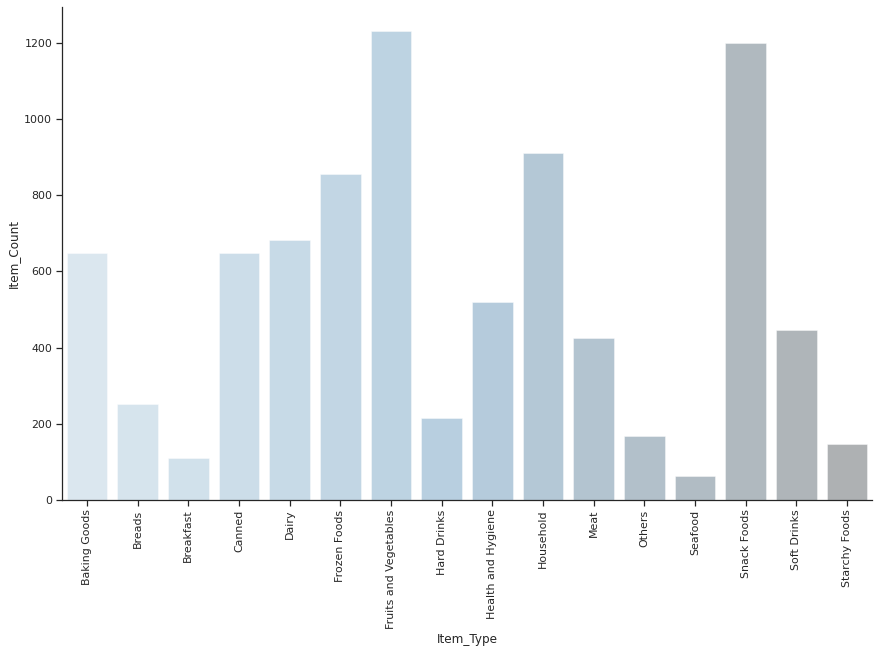

In [91]:
sns.set_style('ticks')
graph = sns.catplot(data = item_df , kind = 'bar' ,x = 'Item_Type', y = 'Item_Count',  palette="Blues_d", alpha=.4, height=6 )
plt.gcf().set_size_inches(15, 8)
plt.xticks(rotation=90)

In [92]:
item_vis = round(sales_df.groupby(['Item_Type'])['Item_Visibility'].mean(),2)
item_vis

Item_Type
Baking Goods             0.07
Breads                   0.07
Breakfast                0.09
Canned                   0.07
Dairy                    0.07
Frozen Foods             0.07
Fruits and Vegetables    0.07
Hard Drinks              0.06
Health and Hygiene       0.06
Household                0.06
Meat                     0.06
Others                   0.06
Seafood                  0.07
Snack Foods              0.07
Soft Drinks              0.06
Starchy Foods            0.07
Name: Item_Visibility, dtype: float64

In [93]:
item2_df = item_vis.reset_index()
item2_df

,Item_Type,Item_Visibility
0,Baking Goods,0.07
1,Breads,0.07
2,Breakfast,0.09
3,Canned,0.07
4,Dairy,0.07
5,Frozen Foods,0.07
6,Fruits and Vegetables,0.07
7,Hard Drinks,0.06
8,Health and Hygiene,0.06
9,Household,0.06


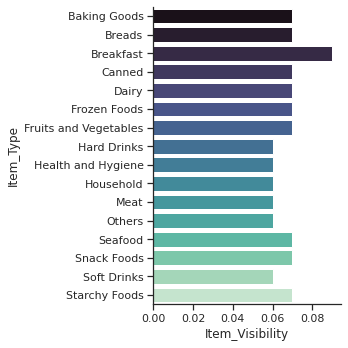

In [94]:
graph2 = sns.catplot(x = "Item_Visibility", y = "Item_Type",kind = 'bar', orient= 'h' , data = item2_df, palette = 'mako')

In [95]:
sns.set() #empiezo a relizar los ajustes de estilo que deseo observar en mis graficos 
sns.set_style('whitegrid') #escojo el stilo de fonfo y cuadricula de mis futuros graficos 
sns.set_style('ticks') #Le digo que todos mis graficos cuenten con el idicador de linea para los datos de los ejes

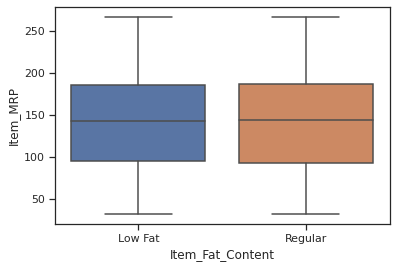

In [96]:
sns.boxplot (x ='Item_Fat_Content' ,y ='Item_MRP',data = sales_df) # este al estar usando el stilo dark devuelve el grafico 
#con un fondo oscuro y el argumento fit_reg nos indica si deseamos la linea de tendencia o la omitimos en este caso fue omitida

### Prediccion ventas Modelo

In [97]:
#Tranformo mis variables objetos en variable categoricas 
sales_df['Item_Fat_Content'] = sales_df['Item_Fat_Content'].astype('category')
sales_df['Outlet_Size'] = sales_df['Outlet_Size'].astype('category')
sales_df['Outlet_Location_Type'] = sales_df['Outlet_Location_Type'].astype('category')
sales_df['Outlet_Type'] = sales_df['Outlet_Type'].astype('category')
sales_df['Item_Identifier'] = sales_df['Item_Identifier'].astype('category')
sales_df['Item_Type'] = sales_df['Item_Type'].astype('category')
sales_df['Outlet_Identifier'] = sales_df['Outlet_Identifier'].astype('category')
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   index                      8523 non-null   int64   
 1   Item_Identifier            8523 non-null   category
 2   Item_Weight                8523 non-null   float64 
 3   Item_Fat_Content           8523 non-null   category
 4   Item_Visibility            8523 non-null   float64 
 5   Item_Type                  8523 non-null   category
 6   Item_MRP                   8523 non-null   float64 
 7   Outlet_Identifier          8523 non-null   category
 8   Outlet_Establishment_Year  8523 non-null   int64   
 9   Outlet_Size                8523 non-null   category
 10  Outlet_Location_Type       8523 non-null   category
 11  Outlet_Type                8523 non-null   category
 12  Item_Outlet_Sales          8523 non-null   float64 
dtypes: category(7), float64(4), int64

In [98]:
sales_df.head()

,index,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,2839,NCZ54,14.65,Low Fat,0.083359,Household,161.9552,OUT046,1997,Small,Tier 1,Supermarket Type1,4711.2008
1,214,NCZ54,14.65,Low Fat,0.000000,Household,161.5552,OUT010,1998,Medium,Tier 3,Grocery Store,324.9104
2,7166,NCZ54,14.65,Low Fat,0.145952,Household,160.9552,OUT019,1985,Small,Tier 1,Grocery Store,162.4552
3,1969,NCZ54,14.65,Low Fat,0.083528,Household,162.4552,OUT045,2002,Medium,Tier 2,Supermarket Type1,2274.3728
4,1896,NCZ54,14.65,Low Fat,0.082956,Household,164.0552,OUT027,1985,Medium,Tier 3,Supermarket Type3,5523.4768


In [99]:
lc_sales_df = sales_df.copy() #genero una copia de mi data frame 
#utilizo el modelo cat codes para dar valores a mis variables categoricas estos
lc_sales_df['Item_Fat_Content'] = lc_sales_df['Item_Fat_Content'].cat.codes
lc_sales_df['Outlet_Size'] = lc_sales_df['Outlet_Size'].astype('category').cat.codes
lc_sales_df['Outlet_Location_Type'] = lc_sales_df['Outlet_Location_Type'].astype('category').cat.codes
lc_sales_df['Outlet_Type'] = lc_sales_df['Outlet_Type'].astype('category').cat.codes
lc_sales_df['Item_Identifier'] = lc_sales_df['Item_Identifier'].astype('category').cat.codes
lc_sales_df['Item_Type'] = lc_sales_df['Item_Type'].astype('category').cat.codes
lc_sales_df['Outlet_Identifier'] = lc_sales_df['Outlet_Identifier'].astype('category').cat.codes 

In [100]:
lc_sales_df.head(5)

,index,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,2839,1558,14.65,0,0.083359,9,161.9552,8,1997,2,0,1,4711.2008
1,214,1558,14.65,0,0.000000,9,161.5552,0,1998,1,2,0,324.9104
2,7166,1558,14.65,0,0.145952,9,160.9552,4,1985,2,0,0,162.4552
3,1969,1558,14.65,0,0.083528,9,162.4552,7,2002,1,1,1,2274.3728
4,1896,1558,14.65,0,0.082956,9,164.0552,5,1985,1,2,3,5523.4768


In [101]:
lc_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      8523 non-null   int64  
 1   Item_Identifier            8523 non-null   int16  
 2   Item_Weight                8523 non-null   float64
 3   Item_Fat_Content           8523 non-null   int8   
 4   Item_Visibility            8523 non-null   float64
 5   Item_Type                  8523 non-null   int8   
 6   Item_MRP                   8523 non-null   float64
 7   Outlet_Identifier          8523 non-null   int8   
 8   Outlet_Establishment_Year  8523 non-null   int64  
 9   Outlet_Size                8523 non-null   int8   
 10  Outlet_Location_Type       8523 non-null   int8   
 11  Outlet_Type                8523 non-null   int8   
 12  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int16(1), int64(2), int8(6)
memor

In [102]:
colnames = lc_sales_df.columns.values.tolist()
predictors1 = colnames[2:11]
target = colnames[12]

In [103]:
X = lc_sales_df[predictors1]
X.shape

(8523, 9)

In [104]:
y = lc_sales_df[target]
y.shape

(8523,)

In [105]:
sales_corr = round(sales_df.corr(),2)
sales_corr

,index,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
index,1.00,-0.03,-0.00,0.00,0.00,-0.01
Item_Weight,-0.03,1.00,-0.01,0.02,-0.01,0.01
Item_Visibility,-0.00,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.00,0.02,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,0.00,-0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,-0.01,0.01,-0.13,0.57,-0.05,1.00


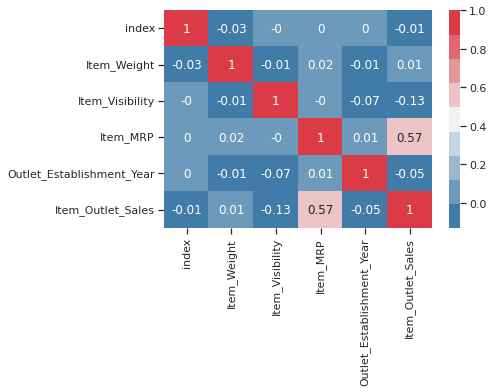

In [106]:
sns.heatmap(sales_corr, cmap = sns.diverging_palette(240, 10, n=9), annot= True) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25d4e96c50>,
      dtype=object)

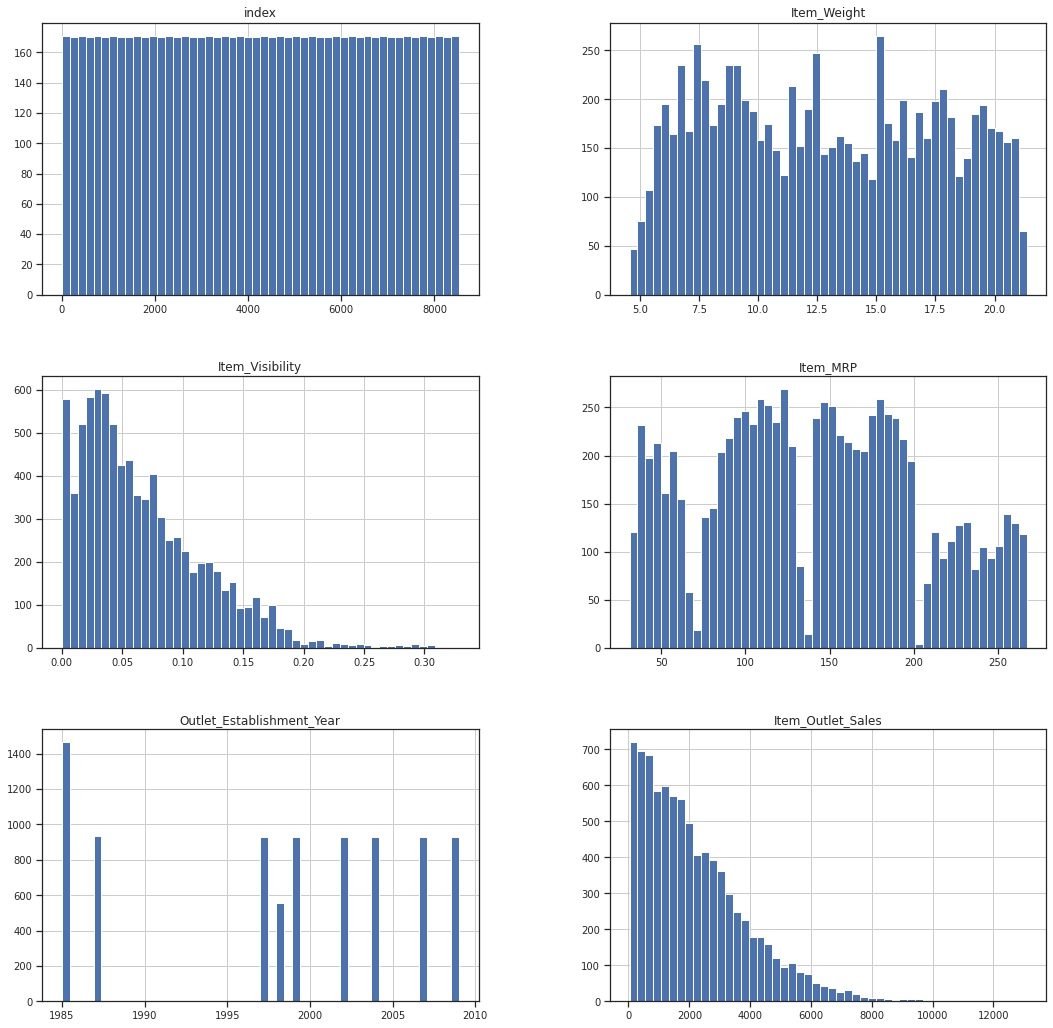

In [107]:
sales_df.loc[:,:].hist(bins=50, figsize=(18,18), xlabelsize='10', ylabelsize='10', xrot= 0 ) # en este codigo primero defino todos los valores que deseo visualizar
# en este caso estoy pidiendo todas las columnas y filas ademas el bind que le pido que sean 25 secuencias para fines vizuales y el ta;o de las etiquetas en loes ejes
# ademas del xrot que me permite definir el angulo de las etiquetas en los ejes en este caso al no ser demasiado largas escojo una rotacion de 0 grados 

In [108]:
lreg = LinearRegression(fit_intercept=True)
lreg

LinearRegression()

In [109]:
lreg.fit(X,y) 

LinearRegression()

In [110]:
np.around(lreg.predict(X[0:100]),2)

array([2308.27, 2036.58, 1158.86, 2992.37, 3372.72, 2594.41, 2803.28,
       3096.59, 2996.84, 3923.38, 2368.06, 3378.1 , 3808.26, 3761.69,
       4125.93, 3231.71, 2896.  , 2207.59, 2456.55, 1939.14, 1957.83,
       1015.27, 2856.5 , 1982.74, 1102.  , 2497.24, 1317.12, 2284.8 ,
       1942.36, 2482.18, 1766.97, 1212.82, 1938.47, 4013.34, 3526.47,
       2171.27, 3758.83, 3624.96, 3187.48, 4203.87, -142.43,  637.6 ,
       1456.2 , -193.63,  405.77, 1061.93, 2575.81, 3983.53, 3677.31,
       2981.93, 4180.04, 3845.75, 4746.88, 1624.02,  393.78, 1616.21,
       2362.48, 3284.47, 2236.04, 2785.05, 1860.29,  840.91, 1608.8 ,
       2595.33, 1836.17, 2713.39, 2358.47, 2211.92, 2860.62,  347.39,
        887.45, -402.1 , 1071.89, -212.05, 1390.02,  480.  , 2855.13,
       3410.01, 2711.68, 2921.91,  836.62,  928.01,  -76.63,  693.06,
        822.57, -439.44, 1710.86, 1335.26, 2790.51, 2609.77, 3700.03,
       3346.91, 2127.97, 2916.59, 3137.58, 2751.68, 1890.38,  446.11,
        274.43,  414

In [111]:
coef = np.around(lreg.coef_,1)
coef.shape

(9,)

In [112]:
intercept = np.around(lreg.intercept_,2)
intercept

16491.93

In [113]:
r_2 = round(lreg.score(X,y),2)
print( 'El valor r cuadrdrado es de:', r_2)

El valor r cuadrdrado es de: 0.45


### Este modelo fue revisado con el anterior y se decide retirar una de las variables aumentando significativamente el rcuadrado 

### Validacion del modelo 

In [114]:
scaler = StandardScaler() #creuna variable que permita standarizar los datos 
scaler.fit(X) #calcula el promedio de la desviacion estandar de uno  de los conjuntos creados 
X = scaler.transform(X) #utlizamos el escaaldo para estandarizar los datos de los conjuntos

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [116]:
lreg.fit(X_test,y_test)

LinearRegression()

In [117]:
lreg.predict(X_test[0:10])

array([1687.36182158, 3030.99958894,  788.66742646, 2346.2909169 ,
       1973.17856126,   84.74453561, 2318.32839576, 1222.54355671,
       2269.47440917, 4194.23715879])

In [118]:
r_2 = round(lreg.score(X_test, y_test),2)
print( 'El valor r cuadrdrado es de:', r_2)

El valor r cuadrdrado es de: 0.44


#### Una vez que se valida el modelo podemos encontrar que una vez realizada la misma el modelo mantiene una tasa de juste por encima del 40%

In [119]:
import statsmodels.api as sm

In [120]:
model = sm.GLS(y, X)
results = model.fit()
print(results.summary())

                                 GLS Regression Results                                
Dep. Variable:      Item_Outlet_Sales   R-squared (uncentered):                   0.170
Model:                            GLS   Adj. R-squared (uncentered):              0.169
Method:                 Least Squares   F-statistic:                              193.1
Date:                Sun, 13 Feb 2022   Prob (F-statistic):                        0.00
Time:                        16:55:34   Log-Likelihood:                         -78859.
No. Observations:                8523   AIC:                                  1.577e+05
Df Residuals:                    8514   BIC:                                  1.578e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Bosque aleatorio 

In [121]:
sales_forest = RandomForestRegressor(n_jobs = 5, oob_score= True, n_estimators= 1000)
sales_forest.fit(X,y)

RandomForestRegressor(n_estimators=1000, n_jobs=5, oob_score=True)

In [122]:
lc_sales_df['prediction_forest'] = sales_forest.oob_prediction_

In [123]:
round(lc_sales_df[['prediction_forest','Item_Outlet_Sales']],2)

,prediction_forest,Item_Outlet_Sales
0,3536.70,4711.20
1,537.01,324.91
2,299.15,162.46
3,4055.20,2274.37
4,4124.05,5523.48
...,...,...
8518,2108.85,2552.68
8519,1908.69,850.89
8520,266.93,283.63
8521,1495.22,3829.02


In [124]:
list(zip(sales_forest.feature_importances_))

[(0.08640260350277477,),
 (0.009579435210954036,),
 (0.10643011461710453,),
 (0.04826648872387196,),
 (0.4403321826302403,),
 (0.17414718544704325,),
 (0.05912667493248268,),
 (0.02397571628437296,),
 (0.051739598651155405,)]

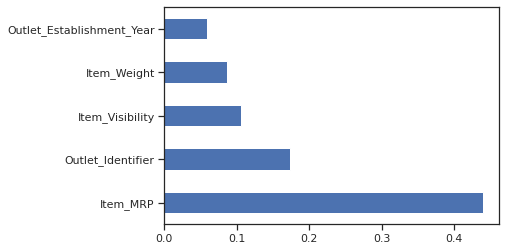

In [125]:
feat_importance = pd.Series(sales_forest.feature_importances_, index = sales_df.columns[2:11])
feat_importance.nlargest(5).plot(kind = 'barh', ) #obtengo las variables mas importantes del modelo 